In [1]:
import sys
sys.path.append("../../")

from dataset_large import get_halo_dataset
from tqdm import tqdm
import numpy as np

# Make sure tf does not hog all the GPU memory
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

%load_ext autoreload
%autoreload 2

2024-05-17 16:16:06.421799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 16:16:06.430784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 16:16:06.787936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
batch_size = 64

dataset, num_total, mean, std, mean_params, std_params = get_halo_dataset(batch_size=batch_size,  # Batch size
                           num_samples=2000,  # If not None, will only take a subset of the dataset
                           split='train',  # 'train', 'val'
                           standardize=True,  # If True, will standardize the features
                           return_mean_std=True,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                           seed=42,  # Random seed
                           features=features,  # Features to include
                           params=params  # Parameters to include
                        )

# Print number of samples
print(f"Number of samples: {num_total}")

Number of samples: 2000


In [3]:
from models.gnn import GNN

In [25]:
# iterator = iter(dataset)

# x_train, params_train = [], []
# for _ in tqdm(range(num_total // batch_size)):
#     x, params = next(iterator)
#     x_train.append(np.array(x))
#     params_train.append(np.array(params))

# x_train = np.concatenate(x_train, axis=0)
# params_train = np.concatenate(params_train, axis=0)

In [26]:
x_train = np.load("../../../BNN_SBI/data/set_diffuser_data/train_halos.npy")[..., :3] / 1000.

import pandas as pd
params_train = pd.read_csv("../../../BNN_SBI/data/set_diffuser_data/train_cosmology.csv",)
params_train = params_train[["Omega_m", "sigma_8"]].values

# Normalize and get std

mean = np.mean(x_train, axis=(0, 1))
std = np.std(x_train, axis=(0, 1))

x_train = (x_train - mean) / std

# Normalize params
mean_params = np.mean(params_train, axis=0)
std_params = np.std(params_train, axis=0)

params_train = (params_train - mean_params) / std_params

In [27]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [28]:
from models.utils.equivariant_graph_utils import get_equivariant_graph
from models.utils.graph_utils import build_graph, compute_distances, nearest_neighbors
from models.utils.irreps_utils import weight_balanced_irreps
from models.segnn import SEGNN
from models.gnn import GNN
from models.utils.graph_utils import get_apply_pbc

In [29]:
_, _, distances = nearest_neighbors(x_train[0], 20)
np.sqrt(np.sum(distances ** 2, axis=-1)).max()

0.69920355

In [30]:
x_train[0] - x_train[1]

array([[-2.7541971e+00,  1.2676725e+00,  1.4447095e+00],
       [ 2.5626147e-01,  1.0286477e+00,  2.0507753e+00],
       [-2.0898473e-01, -7.8270406e-01,  1.2493508e+00],
       ...,
       [ 1.6152114e-03, -8.8632107e-04, -7.9080462e-03],
       [ 3.4317970e-03, -3.3455491e-03, -1.0644794e-03],
       [ 5.0531626e-03,  1.0008812e-03, -1.2727380e-03]], dtype=float32)

In [31]:
get_apply_pbc(std=std,)(x_train[0] - x_train[1])

Array([[ 7.2236538e-01,  1.2676725e+00,  1.4447095e+00],
       [ 2.5626147e-01,  1.0286477e+00, -1.4257872e+00],
       [-2.0898473e-01, -7.8270406e-01,  1.2493508e+00],
       ...,
       [ 1.6152114e-03, -8.8632107e-04, -7.9080462e-03],
       [ 3.4317970e-03, -3.3455491e-03, -1.0644794e-03],
       [ 5.0531626e-03,  1.0008812e-03, -1.2727380e-03]], dtype=float32)

In [32]:
_, _, distances = nearest_neighbors(x_train[0], 20, apply_pbc=get_apply_pbc(std=std,))
np.sqrt(np.sum(distances ** 2, axis=-1)).max()

0.50644416

(array([ 70.,  34.,  52., 111., 147., 160., 206., 126.,  64.,  30.]),
 array([1.73205081e-07, 4.21254337e-02, 8.42506960e-02, 1.26375958e-01,
        1.68501213e-01, 2.10626483e-01, 2.52751738e-01, 2.94876993e-01,
        3.37002277e-01, 3.79127532e-01, 4.21252787e-01]),
 [<matplotlib.patches.Polygon at 0x154b747ec2e0>])

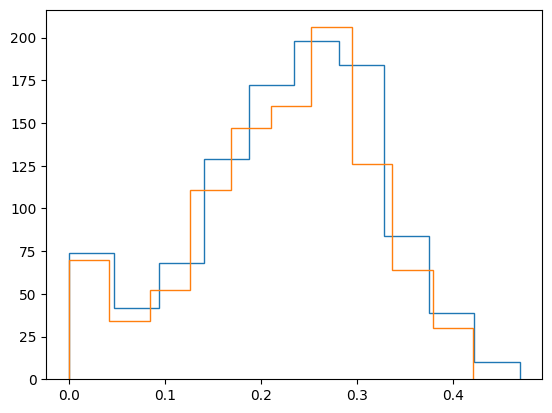

In [33]:
import matplotlib.pyplot as plt

plt.hist(build_graph(x_train[:1], None, 20, n_radial_basis=0, apply_pbc=None).edges.flatten()[:1000], histtype='step')
plt.hist(build_graph(x_train[:1], None, 20, n_radial_basis=0, apply_pbc=get_apply_pbc(std=std,)).edges.flatten()[:1000], histtype='step')

In [34]:
build_graph(x_train[:1], None, 20, n_radial_basis=0, apply_pbc=get_apply_pbc(std=std,)).edges.max()

Array(0.50644416, dtype=float32)

In [35]:
compute_distances(x_train[0],).max()

Array(5.6649594, dtype=float32)

In [69]:
import e3nn_jax as e3nn
from typing import Dict
import jax

use_pbcs = True
apply_pbc = get_apply_pbc(std=std,) if use_pbcs else None
k = 20
n_radial = 24

# SEGNN_PARAMS = {
#     "d_hidden": 64,
#     "l_max_hidden": 1,
#     "num_blocks": 3,
#     "num_message_passing_steps": 3,
#     "intermediate_hidden_irreps": True,
#     "task": "graph",
#     "output_irreps": e3nn.Irreps("1x0e"),
#     "hidden_irreps": weight_balanced_irreps(lmax=1,
#                                             scalar_units=64,
#                                             irreps_right=e3nn.Irreps.spherical_harmonics(1),
#                                             ),
#     "normalize_messages": True,
#     "message_passing_agg": "sum",
#     "readout_agg": "mean",
#     "n_outputs": 2,
#     "scalar_activation": "gelu",
# }

# class GraphWrapper(nn.Module):
#     param_dict: Dict

#     @nn.compact
#     def __call__(self, x):

#         positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
#         if x.nodes.shape[-1] == 3:
#             nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
#             velocities = None
#         else:
#             nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
#             velocities = e3nn.IrrepsArray("1o", x.nodes[..., 3:6])

        
#         st_graph = get_equivariant_graph(
#             node_features=nodes,
#             positions=positions,
#             velocities=None,
#             steerable_velocities=False,
#             senders=x.senders,
#             receivers=x.receivers,
#             n_node=x.n_node,
#             n_edge=x.n_edge,
#             globals=x.globals,
#             edges=None,
#             lmax_attributes=1,
#             apply_pbc=apply_pbc
#         )
        
#         return jax.vmap(SEGNN(**self.param_dict))(st_graph)
    
class GraphWrapper(nn.Module):

    @nn.compact
    def __call__(self, x):
        return jax.vmap(GNN(task="graph", n_outputs=2, message_passing_agg="sum", mlp_readout_widths=(4,2,2), d_hidden=128, message_passing_steps=3))(x)


In [70]:
graph = build_graph(x_train[:8], 
                None, 
                k=k, 
                apply_pbc=apply_pbc,
                use_edges=True, 
                n_radial_basis=n_radial,
)

# model = GraphWrapper(SEGNN_PARAMS, )
model = GraphWrapper()

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)
out

Array([[-0.14057344, -0.0544054 ],
       [-0.13430308, -0.04485999],
       [-0.14149475, -0.05070437],
       [-0.13145208, -0.04255759],
       [-0.14442132, -0.05856911],
       [-0.12481334, -0.03459662],
       [-0.12088123, -0.03019303],
       [-0.13861947, -0.05046596]], dtype=float32)

In [71]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [72]:
# Define train state and replicate across devices

# Cosine learning rate schedule
# lr = optax.cosine_decay_schedule(2e-4, 5000)
lr = optax.linear_onecycle_schedule(5000, 3e-4)
tx = optax.adamw(learning_rate=lr, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [73]:
def loss_mse(pred_batch, cosmo_batch,):
    return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    halo_graph = build_graph(halo_batch, 
                None, 
                k=k, 
                use_edges=True, 
                apply_pbc=apply_pbc,
                n_radial_basis=n_radial,
    )
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [74]:
n_steps = 5000
n_batch = 32

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x_train.shape[0], shape=(n_batch,))
        
        halo_batch, cosmo_batch = x_train[idx], params_train[idx]

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_2027731/1947668592.py:14: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_2027731/1947668592.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
  0%|          | 1/5000 [00:03<5:21:09,  3.85s/it, loss=0.88246274]/tmp/ipykernel_2027731/1947668592.py:14: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_2027731/1947668592.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tr

In [75]:
# import matplotlib.pyplot as plt

# features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
# params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']

# dataset, num_total = get_halo_dataset(batch_size=50,  # Batch size
#                             num_samples=250,  # If not None, will only take a subset of the dataset
#                             split='val',  # 'train', 'val'
#                             standardize=True,  # If True, will standardize the features
#                             return_mean_std=False,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
#                             seed=42,  # Random seed
#                             features=features,  # Features to include
#                             params=params  # Parameters to include
#                             )

# iterator = iter(dataset)

# x_val, params_val = [], []
# for _ in tqdm(range(num_total // batch_size)):
#     x, params = next(iterator)

#     # Convert to numpy
#     x, params = np.array(x), np.array(params)
    
#     # x_val.append(np.array(x))
#     # params_val.append(np.array(params))

#     graph = build_graph(x, 
#                         None, 
#                         k=10, 
#                         use_edges=True, 
#                         apply_pbc=apply_pbc,
#                         n_radial_basis=0,
#                         )

#     pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

#     plt.scatter(params[:, 0], pred[:, 0], s=10, color='firebrick')
    
# # # # Diagonal line
# # plt.plot([0, 0.5], [0, 0.5])

# plt.xlabel("True")
# plt.ylabel("Predicted")

In [76]:
x_test = np.load("../../../BNN_SBI/data/set_diffuser_data/test_halos.npy")[..., :3] / 1000.
params_test = pd.read_csv("../../../BNN_SBI/data/set_diffuser_data/test_cosmology.csv",)

params_test = params_test[["Omega_m", "sigma_8"]].values

x_test = (x_test - mean) / std
params_test = (params_test - mean_params) / std_params

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

Mean MSE: 0.1213223785161972


Text(0, 0.5, 'Predicted')

<Figure size 1200x600 with 0 Axes>

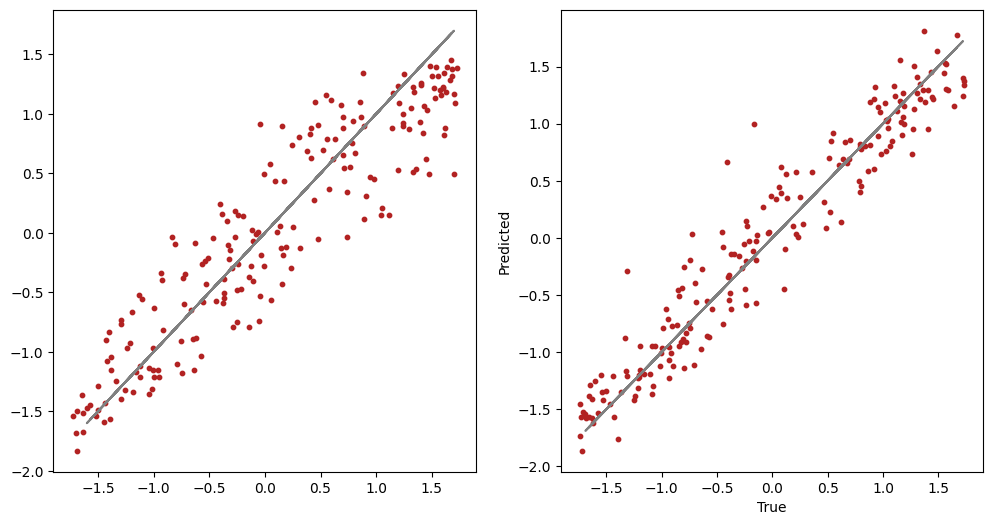

In [77]:
from tqdm import tqdm

n_test_batch = 50
n_test_batches = len(x_test) // n_test_batch

# Make two plots side by side for 0 and 1 idx parameters

plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

mse_list = []

for i in tqdm(range(n_test_batches)):

    # TODO: jit/pmap
    graph = build_graph(x_test[i * n_test_batch:(i + 1) * n_test_batch], 
                        None, 
                        k=k, 
                        use_edges=True, 
                        apply_pbc=apply_pbc,
                        n_radial_basis=n_radial,
                        )

    
    omega_m_pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    ax[0].scatter(params_test[i * n_test_batch:(i + 1) * n_test_batch, 0], omega_m_pred[:, 0], s=10, color='firebrick')
    ax[1].scatter(params_test[i * n_test_batch:(i + 1) * n_test_batch, 1], omega_m_pred[:, 1], s=10, color='firebrick')

    mse_list.append(loss_mse(omega_m_pred, params_test[i * n_test_batch:(i + 1) * n_test_batch]))

print(f"Mean MSE: {np.mean(mse_list)}")
    
ax[0].plot(params_test[:n_test_batch, 0], params_test[:n_test_batch, 0], color='gray')
ax[1].plot(params_test[:n_test_batch, 1], params_test[:n_test_batch, 1], color='gray')

plt.xlabel("True")
plt.ylabel("Predicted")